In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics, neighbors


In [2]:
df_train = pd.read_csv("./data/processed_trainv6.csv")
df_test = pd.read_csv("./data/processed_testv6.csv")

In [3]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,END_LONG,END_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,TARGET
0,0,63,367,-8.618643,41.141412,-8.630838,41.154489,0,0,1,2013,26,6,17,345
1,0,6,371,-8.639847,41.159826,-8.665740,41.170671,0,1,0,2013,26,6,17,285
2,0,63,204,-8.612964,41.140359,-8.615970,41.140530,0,0,1,2013,26,6,17,975
3,0,63,330,-8.574678,41.151951,-8.607996,41.142915,0,0,1,2013,26,6,17,645
4,0,63,217,-8.645994,41.180490,-8.687268,41.178087,0,0,1,2013,26,6,17,435


In [4]:
df_train["HR"].to_numpy().reshape(-1, 1).shape

(1710660, 1)

In [5]:
train_arr = np.loadtxt("./data/processed_trainv6.csv", delimiter=",", skiprows=1)
test_arr = np.loadtxt("./data/processed_testv6.csv", delimiter=",", skiprows=1)

### Approximate starting coords in test set

In [6]:
KNN = dict()
for i in df_test["TAXI_ID"].unique():
    KNN[i] = neighbors.NearestNeighbors(n_neighbors=1)
    KNN[i].fit(train_arr[train_arr[:, 2] == i, 10:-1])

In [7]:
# Nearest neighbors in time
coords = np.zeros((len(df_test), 2))
for i in range(len(df_test)):
    neighbor_idx = KNN[test_arr[i, 2]].kneighbors(test_arr[i, 6:].reshape(1, -1), n_neighbors=1)[1][0][0]
    neighbor = df_train[df_train["TAXI_ID"] == test_arr[i, 2]].iloc[neighbor_idx]
    coords[i] = [neighbor["END_LONG"], neighbor["END_LAT"]]


In [8]:
df_test[["START_LONG", "START_LAT"]] = coords

In [9]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,END_LONG,END_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,TARGET
0,0,63,367,-8.618643,41.141412,-8.630838,41.154489,0,0,1,2013,26,6,17,345
1,0,6,371,-8.639847,41.159826,-8.665740,41.170671,0,1,0,2013,26,6,17,285
2,0,63,204,-8.612964,41.140359,-8.615970,41.140530,0,0,1,2013,26,6,17,975
3,0,63,330,-8.574678,41.151951,-8.607996,41.142915,0,0,1,2013,26,6,17,645
4,0,63,217,-8.645994,41.180490,-8.687268,41.178087,0,0,1,2013,26,6,17,435


### Calculate distances from city center

In [10]:
import math
# Haversine distance assumes first coord lat second coord long
central_long = df_train[df_train["A"] == 1]["START_LONG"].median()
central_lat = df_train[df_train["A"] == 1]["START_LAT"].median()
center = np.array([central_lat, central_long], dtype=np.float64)
center = np.radians(center)

coords_train = df_train[["START_LAT", "START_LONG"]].to_numpy()
coords_train = np.radians(coords_train)
dists_train = metrics.pairwise.haversine_distances(coords_train, center.reshape(1, -1))
dists_train *= 6371000/1000
coords_test = df_test[["START_LAT", "START_LONG"]].to_numpy()
coords_test = np.radians(coords_test)
dists_test = metrics.pairwise.haversine_distances(coords_test, center.reshape(1, -1))
dists_test *= 6371000/1000

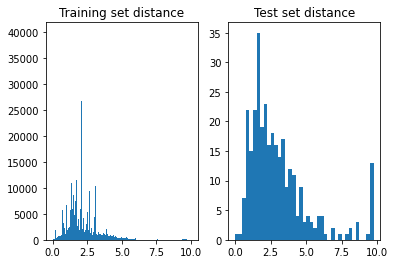

In [11]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.title("Training set distance")
plt.hist(dists_train, bins=np.arange(0, 10, 0.01))
plt.subplot(1, 2, 2)
plt.title("Test set distance")
plt.hist(dists_test, bins=np.arange(0, 10, 0.25))
plt.show()

In [12]:
df_train["DIST"] = dists_train
df_test["DIST"] = dists_test

In [13]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,END_LONG,END_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,TARGET,DIST
0,0,63,367,-8.618643,41.141412,-8.630838,41.154489,0,0,1,2013,26,6,17,345,2.008737
1,0,6,371,-8.639847,41.159826,-8.665740,41.170671,0,1,0,2013,26,6,17,285,1.661882
2,0,63,204,-8.612964,41.140359,-8.615970,41.140530,0,0,1,2013,26,6,17,975,2.202881
3,0,63,330,-8.574678,41.151951,-8.607996,41.142915,0,0,1,2013,26,6,17,645,3.885076
4,0,63,217,-8.645994,41.180490,-8.687268,41.178087,0,0,1,2013,26,6,17,435,3.194961


In [14]:
# Reorder columns
df_train.drop(columns=["END_LONG", "END_LAT"], inplace=True)
df_train.head()
cols = ["ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "START_LONG", "START_LAT", "A", "B", "C", "YEAR", "WK_OF_YR", "WK_DAY", "HR", "DIST", "TARGET"]
df_train = df_train[cols]
df_test = df_test[cols[:-1]]

In [15]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,DIST,TARGET
0,0,63,367,-8.618643,41.141412,0,0,1,2013,26,6,17,2.008737,345
1,0,6,371,-8.639847,41.159826,0,1,0,2013,26,6,17,1.661882,285
2,0,63,204,-8.612964,41.140359,0,0,1,2013,26,6,17,2.202881,975
3,0,63,330,-8.574678,41.151951,0,0,1,2013,26,6,17,3.885076,645
4,0,63,217,-8.645994,41.180490,0,0,1,2013,26,6,17,3.194961,435


### One-hot encoding for times

In [16]:
year_encoder = preprocessing.OneHotEncoder()
year_encoder.fit(df_train[["YEAR", "WK_OF_YR", "WK_DAY", "HR"]])

OneHotEncoder()

In [17]:
transformed = year_encoder.transform(df_train[["YEAR","WK_OF_YR", "WK_DAY", "HR"]].to_numpy())
#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame.sparse.from_spmatrix(transformed)
ohe_df.columns = year_encoder.get_feature_names_out()
#concat with original data
df_train = pd.concat([df_train, ohe_df], axis=1).drop(["YEAR","WK_OF_YR", "WK_DAY", "HR"], axis=1)

transformed = year_encoder.transform(df_test[["YEAR","WK_OF_YR", "WK_DAY", "HR"]].to_numpy())
#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame.sparse.from_spmatrix(transformed)
ohe_df.columns = year_encoder.get_feature_names_out()
#concat with original data
df_test = pd.concat([df_test, ohe_df], axis=1).drop(["YEAR","WK_OF_YR", "WK_DAY", "HR"], axis=1)

In [18]:
df_test.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,DIST
0,0,14,342,-8.615268,41.140188,0,1,0,2014,33,3,10,2.177986
1,0,56,78,-8.685387,41.164857,0,1,0,2014,33,3,10,5.506525
2,0,14,239,-8.683758,41.197752,0,1,0,2014,33,3,10,6.827327
3,0,52,309,-8.629110,41.156478,0,1,0,2014,33,3,10,0.830952
4,0,17,393,-8.607456,41.144139,0,1,0,2014,33,3,10,2.000293


In [19]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,DIST,TARGET
0,0,63,367,-8.618643,41.141412,0,0,1,2013,26,6,17,2.008737,345
1,0,6,371,-8.639847,41.159826,0,1,0,2013,26,6,17,1.661882,285
2,0,63,204,-8.612964,41.140359,0,0,1,2013,26,6,17,2.202881,975
3,0,63,330,-8.574678,41.151951,0,0,1,2013,26,6,17,3.885076,645
4,0,63,217,-8.645994,41.180490,0,0,1,2013,26,6,17,3.194961,435


In [20]:
df_train["TARGET"]

0          345
1          285
2          975
3          645
4          435
          ... 
1710655    480
1710656    450
1710657      0
1710658    930
1710659    405
Name: TARGET, Length: 1710660, dtype: int64

In [21]:
df_train_target = df_train["TARGET"]
df_train.drop(labels="TARGET", inplace=True, axis=1)
df_train["TARGET"] = df_train_target

In [22]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,DIST,TARGET
0,0,63,367,-8.618643,41.141412,0,0,1,2013,26,6,17,2.008737,345
1,0,6,371,-8.639847,41.159826,0,1,0,2013,26,6,17,1.661882,285
2,0,63,204,-8.612964,41.140359,0,0,1,2013,26,6,17,2.202881,975
3,0,63,330,-8.574678,41.151951,0,0,1,2013,26,6,17,3.885076,645
4,0,63,217,-8.645994,41.180490,0,0,1,2013,26,6,17,3.194961,435


### Remove outliers

In [23]:
df_train.drop(df_train[df_train["DIST"] > 200].index, inplace=True)
df_train.drop(df_train[df_train["TARGET"] < 50].index, inplace=True)
df_train.drop(df_train[df_train["TARGET"] > 20000].index, inplace=True)

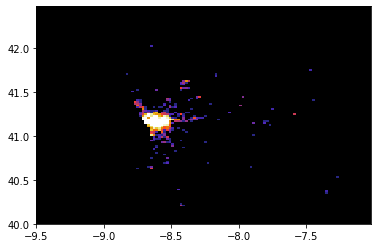

In [24]:
bucket_interval = 0.02
from matplotlib.colors import LogNorm
plt.hist2d(df_train["START_LONG"], df_train["START_LAT"], bins=[np.arange(-9.5, -7, bucket_interval),np.arange(40, 42.5, bucket_interval)], norm=LogNorm(vmax=200, clip=True), cmap="CMRmap")
plt.show()

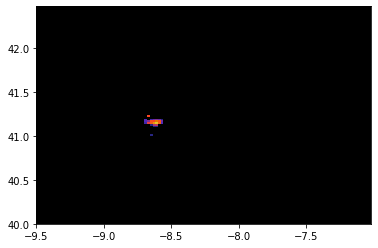

In [53]:
bucket_interval = 0.02
from matplotlib.colors import LogNorm
plt.hist2d(df_test["START_LONG"], df_test["START_LAT"], bins=[np.arange(-9.5, -7, bucket_interval),np.arange(40, 42.5, bucket_interval)], norm=LogNorm(vmax=200, clip=True), cmap="CMRmap")
plt.show()

In [25]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,DIST,TARGET
0,0,63,367,-8.618643,41.141412,0,0,1,2013,26,6,17,2.008737,345
1,0,6,371,-8.639847,41.159826,0,1,0,2013,26,6,17,1.661882,285
2,0,63,204,-8.612964,41.140359,0,0,1,2013,26,6,17,2.202881,975
3,0,63,330,-8.574678,41.151951,0,0,1,2013,26,6,17,3.885076,645
4,0,63,217,-8.645994,41.180490,0,0,1,2013,26,6,17,3.194961,435


### Split to train and validation sets

In [26]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_valid = df_train[int(0.9 * len(df_train)):]
df_train = df_train[:int(0.9 * len(df_train))]
df_train.to_csv("data/processed_trainv6f.csv", index=False)
df_valid.to_csv("data/processed_validv6f.csv", index=False)
df_test.to_csv("data/processed_testv6f.csv", index=False)


In [55]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,DIST,YEAR_2013,...,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,TARGET
0,0,63,55,-8.629605,41.175702,0,0,1,1.978055,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,510
1,6644,63,122,-8.638407,41.159160,1,0,0,1.541139,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1695
2,0,62,299,-8.609607,41.160393,0,1,0,0.876548,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255
3,2,63,31,-8.626167,41.156577,1,0,0,0.606876,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,765
4,0,32,433,-8.599572,41.182551,0,1,0,3.086038,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585


In [57]:
df_test.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,A,B,C,DIST,YEAR_2013,...,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
0,0,14,342,-8.615268,41.140188,0,1,0,2.177986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,56,78,-8.685387,41.164857,0,1,0,5.506525,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,14,239,-8.683758,41.197752,0,1,0,6.827327,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,52,309,-8.629110,41.156478,0,1,0,0.830952,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,17,393,-8.607456,41.144139,0,1,0,2.000293,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TODO: Nuke train set to only contain similar taxi rides

In [56]:
# trimmed_train = df_train[["START_LONG", "START_LAT", "WK_OF_YR", "WK_DAY", "HR", "DIST", "TARGET"]]
# trimmed_test = df_test[trimmed_train.columns[:-1]]
# trimmed_valid = df_valid[trimmed_train.columns]
# trimmed_train.to_csv("data/trimmed_trainv6f.csv", index=False)
# trimmed_valid.to_csv("data/trimmed_validv6f.csv", index=False)
# trimmed_test.to_csv("data/trimmed_testv6f.csv", index=False)

KeyError: "['WK_OF_YR', 'WK_DAY', 'HR'] not in index"